# training.ipynb

Training implementation.

Author: Connacher Murphy

In [4]:
# Libraries
import pest_classification as pest

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import timm
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from types import SimpleNamespace

In [42]:
# Use a super small sample for quick testing
quickly = True

In [43]:
def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    # PyTorch seed
    torch.manual_seed(seed)
    
    # CUDA 1 GPU seed
    torch.cuda.manual_seed(seed)
    
    # CUDA multi-GPU seed
    torch.cuda.manual_seed_all(seed)
    
    # Force deterministic operations in cudnn
    torch.backends.cudnn.deterministic = True
    
    # Disable cudnn auto-tuner
    torch.backends.cudnn.benchmark = False

In [44]:
# Set random seed
set_seed(456)

In [45]:
# Configuration
config = SimpleNamespace(**{})

# Grab training observations from images df
# CM: sampling to speed up execution
df_all = pest.df

if quickly:  # select small sample
    config.total_size = 256
    config.batch_size = 32
    config.num_epochs = 2
else:  # "full" sample
    config.total_size = 2048
    config.batch_size = 64
    config.num_epochs = 4

df = df_all[df_all["set"] == "train_set"].sample(config.total_size)
df = df.reset_index(drop=True)

In [46]:
# Dataset and dataloader
config.image_dir = os.path.expanduser("~/data/ccmt/CCMT Dataset-Augmented")
config.image_size = 256

In [47]:
# Specify architecture parameters
config.num_classes = len(pest.crop_descriptions["Maize"])
config.backbone = "resnet18"

# Specify optimizer parameters
config.lr = 1e-4

In [48]:
# Select GPU if available
print(torch.cuda.is_available())
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

False


In [49]:
# Training function
def train(train_dataloader, model, optimizer, config):
    loss_history = []
    accuracy_history = []
    
    for epoch in range(config.num_epochs):
        print(f"Epoch {epoch + 1}")
        
        model, train_loss, train_accuracy, train_tab = pest.train_epoch(
            train_dataloader, model, optimizer, config
        )
        
        loss_history.append(train_loss)
        accuracy_history.append(train_accuracy)

        train_tab_sum = np.sum(train_tab, axis=1, keepdims=True)

        print(f"Training: loss = {train_loss}, accuracy = {train_accuracy}")
        print("Label versus predicted label tabulation:")
        print(np.round(train_tab / train_tab_sum, 2))
        print(train_tab_sum)
        print("\n")
    
    return model, loss_history, accuracy_history

In [50]:
# Create df and datasets
train_df = df.reset_index(drop=True)
train_dataset = pest.AugmentedCCMT(config, train_df)

# Dataloaders
train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0
)

# Initialize (pre-trained) model
model = timm.create_model(
    config.backbone, pretrained=True, num_classes=config.num_classes
)
model.to(config.device)

# Specify loss function (CM: move this to outer loop?)
config.criterion = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=0.0)

# Call training function
model, loss_history, accuracy_history = train(train_dataloader, model, optimizer, config)

print("\n")

Epoch 1


100%|██████████| 8/8 [00:23<00:00,  2.97s/it]


Training: loss = 1.8856724500656128, accuracy = 0.24609375
Label versus predicted label tabulation:
[[0.   0.   0.   0.2  0.67 0.   0.13]
 [0.   0.   0.   0.11 0.56 0.   0.33]
 [0.   0.   0.   0.   0.62 0.   0.38]
 [0.   0.   0.   0.2  0.59 0.   0.21]
 [0.   0.   0.   0.09 0.64 0.   0.27]
 [0.   0.   0.   0.21 0.62 0.   0.18]
 [0.   0.   0.   0.14 0.53 0.   0.33]]
[[15.]
 [27.]
 [13.]
 [56.]
 [55.]
 [39.]
 [51.]]


Epoch 2


100%|██████████| 8/8 [00:22<00:00,  2.82s/it]

Training: loss = 1.815626710653305, accuracy = 0.31640625
Label versus predicted label tabulation:
[[0.   0.   0.   0.13 0.73 0.   0.13]
 [0.   0.   0.   0.15 0.63 0.   0.22]
 [0.   0.   0.   0.08 0.77 0.   0.15]
 [0.   0.   0.   0.3  0.57 0.   0.12]
 [0.   0.   0.   0.11 0.8  0.   0.09]
 [0.   0.   0.   0.18 0.69 0.   0.13]
 [0.   0.   0.   0.12 0.49 0.   0.39]]
[[15.]
 [27.]
 [13.]
 [56.]
 [55.]
 [39.]
 [51.]]






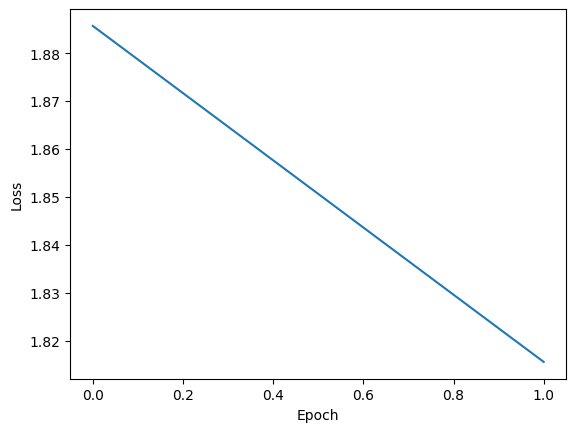

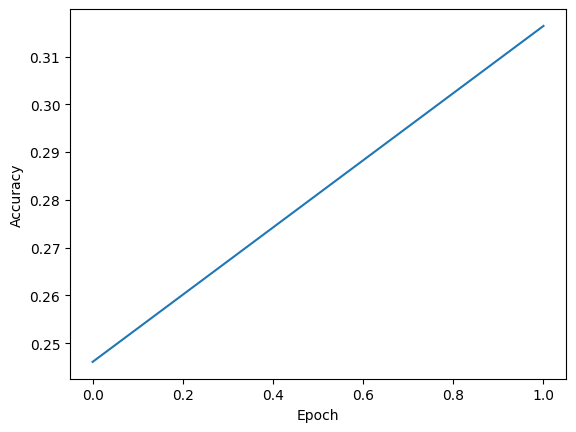

In [51]:
# Summary plots
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.plot(accuracy_history)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [52]:
# Save model
torch.save(model, "model.pth")
# torch.save(model.state_dict(), "model.pth")

# Save in ONNX
# input = torch.randn(1, 3, config.image_size, config.image_size).to(config.device)
# torch.onnx.export(
#     model,
#     input,
#     "model.onnx",
#     # verbose=True,
#     input_names=["input"],
#     output_names=["output"],
# )

# # Convert ONNX to TensorFlow
# model_onnx = onnx.load("model.onnx")
# tf_rep = prepare(model_onnx)

# tf_rep.export_graph("tf_rep")

# # Convert TensorFlow to TFLite
# converter = tf.lite.TFLiteConverter.from_saved_model("tf_rep")
# tflite_model = converter.convert()

# with open("model.tflite", "wb") as f:
#     f.write(tflite_model)

In [53]:
with open("crop_descriptions.pkl", "wb") as f:
    pickle.dump(pest.crop_descriptions, f)

In [5]:
# Open a file for writing
with open("index_to_name.json", "w") as f:
    # Write the dictionary to the file as JSON
    json.dump(pest.crop_descriptions["Maize"], f)

# json_str = json.dumps()

In [6]:
pest.crop_descriptions["Maize"]

['leaf beetle',
 'healthy',
 'leaf blight',
 'grasshoper',
 'fall armyworm',
 'streak virus',
 'leaf spot']